## Importing all the libaries

In [ ]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer

## Reading  data

In [ ]:
dataset = pd.read_csv("preprocessed_dataset.csv")
print(dataset)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


## Data preperation

In [ ]:
X = pd.Series(dataset["review"])
y = dataset["sentiment"].replace({"positive":0,"negative":1})

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.10)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.2)

In [ ]:
print("The number of samples in X_train",X_train.shape)
print("The number of samples in X_test",X_test.shape)
print("The number of samples in X_valid",X_valid.shape)
print("The number of samples in y_train",y_train.shape)
print("The number of samples in y_test",y_test.shape)
print("The number of samples in y_valid",y_valid.shape)

The number of samples in X_train (36000,)
The number of samples in X_test (5000,)
The number of samples in X_valid (9000,)
The number of samples in y_train (36000,)
The number of samples in y_test (5000,)
The number of samples in y_valid (9000,)


## Tokenizer creates a unique id for each word

In [ ]:
vocab_size = 1000
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

## texts_to_sequences() converts word to unqiue id

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)
X_test = tokenizer.texts_to_sequences(X_test)

## Setting maxlen sequence to average of lengths of all sequences

In [ ]:
lengths = [len(i) for i in X_train]
maxlen = int(sum(lengths)/len(lengths))

## It pads if length is less than maxlen else truncate sequence

In [ ]:
from keras.preprocessing import sequence
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_valid = sequence.pad_sequences(X_valid, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [ ]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,  18,   5, 319,   4,   5,   1,   6,   1,  44,  21,  23,   5,
       311,   6, 959,  97,  18,  58, 999, 147,   1,   5, 642,  66, 652,
       275,   4,   1, 333, 155,  11,  20,   1,  30, 394,  28,   1,  21,
        78, 227,  95,   5, 718,  16,  18,   5, 359,   6, 347,   

# Model 1 

In [ ]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_vecor_length, input_length=maxlen))
model.add(Dropout(0.2))
model.add(LSTM(100))
#model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 234, 32)           32032     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 234, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 85,333
Trainable params: 85,333
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
def plot(history):
  plt.figure(0)
  plt.plot(history.history['accuracy'], label='training accuracy')
  plt.plot(history.history['val_accuracy'], label='val accuracy')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  plt.figure(1)
  plt.plot(history.history['loss'], label='training loss')  
  plt.plot(history.history['val_loss'], label='val loss')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

In [ ]:
history = model.fit(X_train, y_train, batch_size=64,epochs=25, validation_data=(X_valid, y_valid))

Epoch 1/25
563/563 [==============================] - 32s 20ms/step - loss: 0.6116 - accuracy: 0.6512 - val_loss: 0.3376 - val_accuracy: 0.8572
Epoch 2/25
563/563 [==============================] - 10s 17ms/step - loss: 0.3394 - accuracy: 0.8565 - val_loss: 0.3273 - val_accuracy: 0.8667
Epoch 3/25
563/563 [==============================] - 10s 17ms/step - loss: 0.3000 - accuracy: 0.8786 - val_loss: 0.2989 - val_accuracy: 0.8746
Epoch 4/25
563/563 [==============================] - 10s 17ms/step - loss: 0.2885 - accuracy: 0.8799 - val_loss: 0.3056 - val_accuracy: 0.8739
Epoch 5/25
563/563 [==============================] - 10s 17ms/step - loss: 0.2742 - accuracy: 0.8852 - val_loss: 0.3115 - val_accuracy: 0.8698
Epoch 6/25
563/563 [==============================] - 10s 17ms/step - loss: 0.2608 - accuracy: 0.8928 - val_loss: 0.3031 - val_accuracy: 0.8750
Epoch 7/25
563/563 [==============================] - 10s 17ms/step - loss: 0.2550 - accuracy: 0.8945 - val_loss: 0.3174 - val_accuracy:

In [ ]:
score = model.evaluate(X_test, y_test)

157/157 [==============================] - 1s 7ms/step - loss: 0.3557 - accuracy: 0.8596


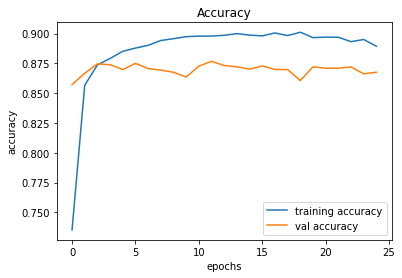

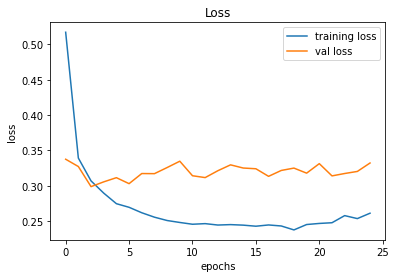

In [ ]:
plot(history)

Model overfits clearly

# Model 2

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=3,restore_best_weights=True)

In [ ]:
embedding_vecor_length = 32
model_1 = Sequential()
model_1.add(Embedding(vocab_size+1, embedding_vecor_length, input_length=maxlen))
model_1.add(Dropout(0.2))
model_1.add(LSTM(80))
#model.add(BatchNormalization())
model_1.add(Dropout(0.2))
model_1.add(Dense(1, activation='sigmoid'))
opt = Adam(learning_rate=0.01)
model_1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 234, 32)           32032     
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 234, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                36160     
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 81        
Total params: 68,273
Trainable params: 68,273
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model_1.fit(X_train, y_train, validation_data=(X_valid,y_valid), epochs=25,batch_size=64, verbose=0, callbacks=[es])

Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


In [ ]:
print("The number of epoch model run",len(history.history["loss"]))

The number of epoch model run 4


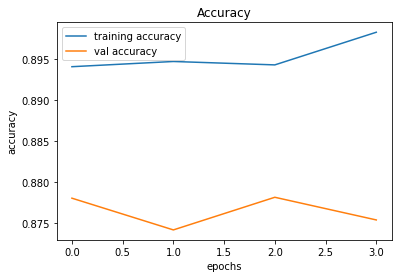

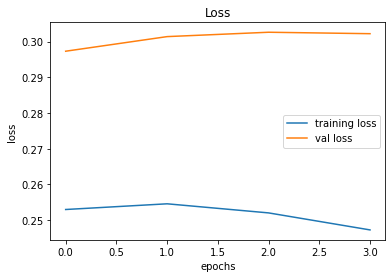

In [ ]:
plot(history)

In [ ]:
score = model_1.evaluate(X_test, y_test)

157/157 [==============================] - 1s 7ms/step - loss: 0.3229 - accuracy: 0.8646
